# Atividade 3 - Case
  
#### Conforme planilha de dados fornecida. 
Deseja-se prospectar empresas que possuam soluções em **tratamento de água** , 
principalmente,  elativas à : **solutions on waste and water, Improve water quality and
water efficiency use, water contamination, water for human consumption, water resources** .

### Declarações Importações de Libs

In [1]:
import re
from pathlib import Path
import pickle
import joblib
import pandas as pd
import spacy
import scipy.sparse
from sklearn.feature_extraction.text import (TfidfVectorizer,
                                             CountVectorizer)
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack, csr_matrix
from gensim import matutils
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import matplotlib.pyplot as plt
import seaborn as sns

#import missingno as msno

/home/pabloernesto/anaconda3/envs/firstenv/lib/python3.10/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


### Declarações de Funções

In [2]:
def analyze_text_columns(df):
    # Lista para armazenar os resultados
    results = []
    # Regex para identificar strings que contêm apenas caracteres especiais (e espaços)
    regex_special_chars_only = re.compile(r'^[\W_]+$')
    # Iterando sobre cada coluna do DataFrame
    for column in df.columns:
        # Verificando se o tipo da coluna é 'object', indicando texto
        if df[column].dtype == 'object':
            # Contando valores nulos
            null_values = df[column].isnull().sum()
            # Contando strings vazias
            empty_strings = (df[column] == '').sum()
            # Contando strings somente com espaços
            only_spaces = df[column].apply(lambda x: x.isspace() if isinstance(x, str) else False).sum()
            # Contando registros que contêm apenas caracteres especiais (e possivelmente espaços)
            special_chars_only = df[column].apply(lambda x: bool(regex_special_chars_only.match(x)) if isinstance(x, str) else False).sum()
            # Adicionando resultado à lista
            results.append({
                'coluna': column,
                'valores_nulos': null_values,
                'strings_vazias': empty_strings,
                'strings_somente_espacos': only_spaces,
                'strings_apenas_caracteres_especiais': special_chars_only
            })
    return results


### Declarações de Constantes Globais

In [3]:
ROOT_DIR = Path().absolute()
SOURCE_SUBDIR = 'Data'
DEST_SUBDIR = 'Data'
DATA_FILE_NAME = 'data.parquet'
FULL_DATA_FILE_NAME = ROOT_DIR / SOURCE_SUBDIR / DATA_FILE_NAME

### Carrega de Dados


In [4]:
# Carregando os dados já Corrigidos
df = pd.read_parquet(FULL_DATA_FILE_NAME)

### EDA (Análise Exploratória de Dados)

In [5]:
df.head(2)

,name,description,employees,total_funding,city,subcountry,lat,lng,clean_description,original_water_term_count,altered_water_term_count,topic,extended_water_term_count
0,fitin,"""fitin is the latest fit tech platform that pr...",1.0,nan,toronto,ontario,43.700109999999995,-79.4163\n,fitin late fit tech platform provide professio...,0,0,2,0
1,quinditech,"""our services include independent & collaborat...",10.0,nan,montreal,quebec,45.50884,-73.58781\n,service include independent collaborative ai p...,0,0,1,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19309 entries, 0 to 19308
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   name                       19309 non-null  object
 1   description                19309 non-null  object
 2   employees                  19309 non-null  object
 3   total_funding              19309 non-null  object
 4   city                       19309 non-null  object
 5   subcountry                 19309 non-null  object
 6   lat                        19309 non-null  object
 7   lng                        19309 non-null  object
 8   clean_description          19309 non-null  object
 9   original_water_term_count  19309 non-null  int64 
 10  altered_water_term_count   19309 non-null  int64 
 11  topic                      19309 non-null  int64 
 12  extended_water_term_count  19309 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 1.9+ MB


#### Análise de valores nulos ou inválidos

In [7]:
analyze_text_columns(df)

[{'coluna': 'name',
  'valores_nulos': 0,
  'strings_vazias': 0,
  'strings_somente_espacos': 0,
  'strings_apenas_caracteres_especiais': 1},
 {'coluna': 'description',
  'valores_nulos': 0,
  'strings_vazias': 0,
  'strings_somente_espacos': 0,
  'strings_apenas_caracteres_especiais': 0},
 {'coluna': 'employees',
  'valores_nulos': 0,
  'strings_vazias': 0,
  'strings_somente_espacos': 0,
  'strings_apenas_caracteres_especiais': 0},
 {'coluna': 'total_funding',
  'valores_nulos': 0,
  'strings_vazias': 0,
  'strings_somente_espacos': 0,
  'strings_apenas_caracteres_especiais': 599},
 {'coluna': 'city',
  'valores_nulos': 0,
  'strings_vazias': 0,
  'strings_somente_espacos': 0,
  'strings_apenas_caracteres_especiais': 0},
 {'coluna': 'subcountry',
  'valores_nulos': 0,
  'strings_vazias': 0,
  'strings_somente_espacos': 0,
  'strings_apenas_caracteres_especiais': 0},
 {'coluna': 'lat',
  'valores_nulos': 0,
  'strings_vazias': 0,
  'strings_somente_espacos': 0,
  'strings_apenas_carac

#### Análise dos Dados Textuais  
  
Os dados textuais serão preprocessados e analisados utilizando spaCy, Gensim, e SKLearn

In [8]:
# Carregar o modelo do spaCy
nlp = spacy.load("en_core_web_trf")

def preprocess_text(text):
    # Processar o texto com o spaCy
    doc = nlp(text)
    # Gerar lista de tokens após remover stopwords e pontuação, e aplicar lematização
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    # Juntar os tokens de volta em uma string
    clean_text = ' '.join(tokens)
    return clean_text
# Aplicar a função de pré-processamento à coluna 'description'
df['clean_description'] = df['description'].apply(preprocess_text)

# Visualizar as descrições limpas
print(df[['description', 'clean_description']].head())

                                         description  \
0  "fitin is the latest fit tech platform that pr...   
1  "our services include independent & collaborat...   
2  "chatlanding is a digital chatbot platform whe...   
3  ai-powered army of health professionals in you...   
4  "stylify is a mobile platform that connects pe...   

                                   clean_description  
0  fitin late fit tech platform provide professio...  
1  service include independent collaborative ai p...  
2  chatlanding digital chatbot platform conversat...  
3  ai power army health professional pocket feel ...  
4  stylify mobile platform connect people local i...  


In [9]:
# Salvar os dados processados para intercâmbio com outros testes se for o caso
df.to_parquet(FULL_DATA_FILE_NAME)

In [10]:
# Inicializar o vetorizador TF-IDF
vectorizer = TfidfVectorizer()
# Aplicar TF-IDF às descrições limpas e converter para uma matriz densa
tfidf_matrix = vectorizer.fit_transform(df['clean_description'])
# Visualizar o formato da matriz TF-IDF
print(tfidf_matrix.shape)

(19309, 44347)


In [49]:
# Salvar vetorizador do atributo clean_description
joblib.dump(tfidf_matrix, ROOT_DIR / SOURCE_SUBDIR / 'tfidf_matrix.pkl')

['/media/pabloernesto/Seagate Expansion Drive/Work/Projects/Desafios/FirstDecision/Prospect-Canadian-Water-Companies/Data/tfidf_matrix.pkl']

#### Vetorização dos textos, contagem de palavras, e análise dos termos

/home/pabloernesto/anaconda3/envs/firstenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pabloernesto/anaconda3/envs/firstenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pabloernesto/anaconda3/envs/firstenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


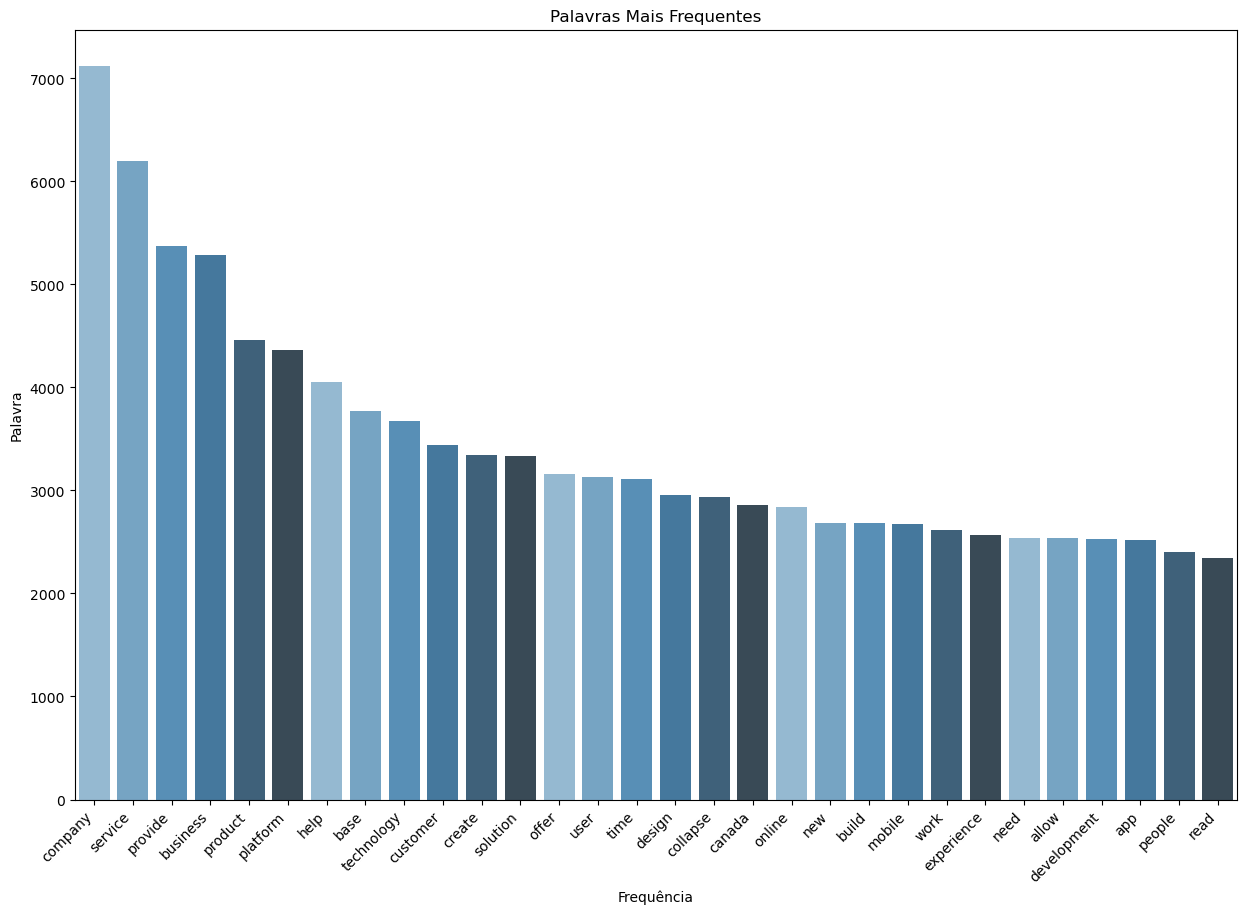

In [11]:
# Usando CountVectorizer para contar as ocorrências das palavras
count_vectorizer = CountVectorizer(stop_words='english')
X = count_vectorizer.fit_transform(df['clean_description'])
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in count_vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
# Aumentando o número de palavras a serem visualizadas
num_palavras = 30  # Aumente este número conforme desejado
# Convertendo a lista de frequências em um DataFrame
words_df = pd.DataFrame(words_freq, columns=['word', 'frequency'])
# Selecionando as palavras mais frequentes para visualização
top_words_df = words_df.head(num_palavras)
# Criando um gráfico de barras horizontal com Seaborn
plt.figure(figsize=(15, 10))
sns.barplot(x='word', y='frequency', data=top_words_df, palette=sns.color_palette("Blues_d"))
plt.title('Palavras Mais Frequentes')
plt.xlabel('Frequência')
plt.ylabel('Palavra')
plt.xticks(rotation=45, ha='right')
plt.show()


In [12]:
# Lista de termos relacionados ao tratamento de água conforme o exercício
original_water_terms = ["waste and water", "water quality", "water efficiency", 
                        "water contamination", "human consumption", "water resources"]

altered_water_terms = original_water_terms + ['water']

# Função para contar a ocorrência de termos específicos
def count_water_terms(text, terms):
    count = 0
    for term in terms:
        # \b é um delimitador de palavra, que considera apenas correspondências completas do termo
        term_pattern = r'\b' + re.escape(term) + r'\b'
        # Contando as ocorrências do termo usando a expressão regular
        count += len(re.findall(term_pattern, text))
    return count

# Aplicar a função ao DataFrame
df['original_water_term_count'] = df['clean_description'].apply(lambda x: count_water_terms(x, original_water_terms))
df['altered_water_term_count'] = df['clean_description'].apply(lambda x: count_water_terms(x, altered_water_terms))


In [13]:
# Visualizando as descrições com maior contagem de termos originais
top_water_descriptions = df.sort_values(by='original_water_term_count', ascending=False).head(20)
print(top_water_descriptions[['description', 'original_water_term_count']])

                                             description  \
3181   "jet set is a line of hot tubs that boast stun...   
11018  "4deep inwater imaging is a privately owned, h...   
4400   "imagine housing solutions that offer: 90% red...   
4786   "aquatic informatics provides leading software...   
368    "we are using advanced stem cell and cell cult...   
10311  "the product is a software that works on cell ...   
12873  "founded in 2002, riverdale partners is a bout...   
12878  "rsi research solutions is a analytics solutio...   
12877  "royal laser mfg inc., is a dynamic manufactur...   
12876  "ronen kurzfeld immigration lawyer provides th...   
12875  "robotshop distribution inc. is the leading on...   
12874  "roar solutions provides website design, email...   
0      "fitin is the latest fit tech platform that pr...   
12880  "sales for life has helped to pioneer social s...   
12872  "rightlabs is a software lab. the two most pop...   
12871  rigel kent security and advisory 

In [14]:
# Visualizando as descrições com maior contagem de termos alterado
top_water_descriptions = df.sort_values(by='altered_water_term_count', ascending=False).head(20)
print(top_water_descriptions[['description', 'altered_water_term_count']])

                                             description  \
18229  "greenlife water is the leading provider of wa...   
354    "o waste r/o out door water vending, electroni...   
10182  "o waste r/o out door water vending, electroni...   
5231   "water is our future! without water we do not ...   
16544  "our vision is to create a cost effective, tec...   
5008   "sanzfield allows homeowners and small communi...   
13391  "tablâ€™eau filtered water provides exceptiona...   
16914  "puritas energy is a green tech company which ...   
10707  "demizine takes artifical intelligence (ai) an...   
4786   "aquatic informatics provides leading software...   
10547  "fer-pal infrastructure is proud to offer a ce...   
16280  "homebeaver is an innovative new automation sy...   
5897   "we are fredsense technologies, a calgary base...   
4123   "alert labsâ€™ insight series protects our cus...   
10663  "provider of water data analysis software inte...   
18344  "ontario consumers home services 

Poucos registros com os termos sugeridos... Porém um número razoável de registros com a palavra "water"

#### Aplicando LDA

##### Definições de Funções para Uso no Texto com LDA

In [15]:
# Utilizando CountVectorizer para a contagem bruta de palavras
count_vectorizer = CountVectorizer(stop_words='english')
X = count_vectorizer.fit_transform(df['clean_description'])
texts = [doc.split() for doc in df['clean_description']]
# Converter a matriz do CountVectorizer para o formato compatível com o Gensim
corpus = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(X.T))
# Criando um mapeamento de id de palavra para palavra (necessário para o modelo LDA)
id2word = {v: k for k, v in count_vectorizer.vocabulary_.items()}
dct = Dictionary.from_corpus(corpus, id2word=id2word)


# Função para treinar o modelo LDA
def train_lda(corpus, dct, num_topics=5, alpha=0.01, eta=0.01):
    lda_model = LdaModel(corpus=corpus, 
                         id2word=dct, 
                         num_topics=num_topics,
                         alpha=alpha, 
                         eta=eta, 
                         random_state=42, 
                         passes=10)
    return lda_model

# Função para visualização com pyLDAvis
def visualize_lda_model(lda_model, corpus, dct):
    vis = gensimvis.prepare(lda_model, corpus, dct, sort_topics=False)
    return vis

# Função fine-tuning para encontrar os melhores parâmtros (número de tópicos, alpha e eta)
def find_best_parameters(dct, corpus, texts, start=2, end=10, alphas=[0.01, 0.1, 'symmetric', 'asymmetric'], etas=[0.01, 0.1, 'symmetric']):
    results = []
    for num_topics in range(start, end):
        for alpha in alphas:
            for eta in etas:
                model = LdaModel(corpus=corpus, 
                                 num_topics=num_topics, 
                                 id2word=dct, 
                                 alpha=alpha, 
                                 eta=eta, 
                                 random_state=42, 
                                 passes=10)
                coherencemodel = CoherenceModel(model=model, 
                                                texts=texts, 
                                                dictionary=dct, 
                                                coherence='c_v')
                coherence = coherencemodel.get_coherence()
                results.append({'num_topics': num_topics, 
                                'alpha': alpha, 
                                'eta': eta, 
                                'coherence': coherence})
                # Imprime os resultados parciais para acompanhar o progresso
                print(f"Num Topics: {num_topics}, Alpha: {alpha}, Eta: {eta}, Coherence: {coherence}")
    # Encontrando a configuração com a maior coerência
    best_result = max(results, key=lambda x: x['coherence'])
    print("\nBest Result:", best_result)
    return results, best_result


# Função para encontrar o melhor número de tópicos
def find_best_num_topics(dct, corpus, texts, start=2, end=10):
    coherence_values = []
    for num_topics in range(start, end):
        model = LdaModel(corpus=corpus, 
                         num_topics=num_topics, 
                         id2word=dct, 
                         random_state=42, 
                         passes=10)
        coherencemodel = CoherenceModel(model=model, 
                                        texts=texts, 
                                        dictionary=dct, 
                                        coherence='c_v')
        coherence_values.append((num_topics, coherencemodel.get_coherence()))
    # Plotando a coerência
    plt.plot([cv[0] for cv in coherence_values], [cv[1] for cv in coherence_values])
    plt.xlabel("Número de Tópicos")
    plt.ylabel("Coerência")
    plt.show()
    return coherence_values


def plot_coherence_by_num_topics(results):
    # Filtrando os resultados para obter apenas os valores únicos de número de tópicos
    unique_num_topics = sorted(set(result['num_topics'] for result in results))
    # Calculando a média da coerência para cada número de tópicos
    avg_coherence_by_num_topics = []
    for num in unique_num_topics:
        coherences = [result['coherence'] for result in results if result['num_topics'] == num]
        avg_coherence = sum(coherences) / len(coherences)
        avg_coherence_by_num_topics.append((num, avg_coherence))
    # Desempacotando os valores para plotagem
    num_topics, coherences = zip(*avg_coherence_by_num_topics)
    # Criando o gráfico
    plt.figure(figsize=(10, 5))
    plt.plot(num_topics, coherences, marker='o')
    plt.title('Coerência Média por Número de Tópicos')
    plt.xlabel('Número de Tópicos')
    plt.ylabel('Coerência Média')
    plt.grid(True)
    plt.show()


# Listagem de número de tópicos e ceherence
def print_coherence_list(results):
    coherence_list = [(result['num_topics'], result['coherence']) for result in results]
    coherence_list = sorted(coherence_list, key=lambda x: x[0])  # Ordenar pela quantidade de tópicos

    print("Listagem de Coerência por Número de Tópicos:")
    for num_topics, coherence in coherence_list:
        print(f"Número de Tópicos: {num_topics}, Coerência: {coherence:.4f}")


##### Buca dos Melhores Parâmetros (Fin-Tunig)

Num Topics: 2, Alpha: 0.01, Eta: 0.01, Coherence: 0.4539684123169325
Num Topics: 2, Alpha: 0.01, Eta: 0.1, Coherence: 0.4539684123169325
Num Topics: 2, Alpha: 0.01, Eta: symmetric, Coherence: 0.44203482172756714
Num Topics: 2, Alpha: 0.1, Eta: 0.01, Coherence: 0.4539684123169325
Num Topics: 2, Alpha: 0.1, Eta: 0.1, Coherence: 0.4539684123169325
Num Topics: 2, Alpha: 0.1, Eta: symmetric, Coherence: 0.4538070386117823
Num Topics: 2, Alpha: symmetric, Eta: 0.01, Coherence: 0.4539684123169325
Num Topics: 2, Alpha: symmetric, Eta: 0.1, Coherence: 0.4539684123169325
Num Topics: 2, Alpha: symmetric, Eta: symmetric, Coherence: 0.4548054392185894
Num Topics: 2, Alpha: asymmetric, Eta: 0.01, Coherence: 0.466143445015732
Num Topics: 2, Alpha: asymmetric, Eta: 0.1, Coherence: 0.46154515140490504
Num Topics: 2, Alpha: asymmetric, Eta: symmetric, Coherence: 0.43218746043135137
Num Topics: 3, Alpha: 0.01, Eta: 0.01, Coherence: 0.5473305595504367
Num Topics: 3, Alpha: 0.01, Eta: 0.1, Coherence: 0.5163

/home/pabloernesto/anaconda3/envs/firstenv/lib/python3.10/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in scalar divide
  m_lr_i = np.log(numerator / denominator)
/home/pabloernesto/anaconda3/envs/firstenv/lib/python3.10/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in scalar divide
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


Num Topics: 8, Alpha: asymmetric, Eta: 0.1, Coherence: nan
Num Topics: 8, Alpha: asymmetric, Eta: symmetric, Coherence: nan
Num Topics: 9, Alpha: 0.01, Eta: 0.01, Coherence: 0.4801383978434432
Num Topics: 9, Alpha: 0.01, Eta: 0.1, Coherence: 0.5221738695530349
Num Topics: 9, Alpha: 0.01, Eta: symmetric, Coherence: 0.48362401930809185
Num Topics: 9, Alpha: 0.1, Eta: 0.01, Coherence: 0.5143799380419818
Num Topics: 9, Alpha: 0.1, Eta: 0.1, Coherence: 0.5015780435802357
Num Topics: 9, Alpha: 0.1, Eta: symmetric, Coherence: 0.5029078891353556
Num Topics: 9, Alpha: symmetric, Eta: 0.01, Coherence: 0.5147797780000365
Num Topics: 9, Alpha: symmetric, Eta: 0.1, Coherence: 0.5044454162117388
Num Topics: 9, Alpha: symmetric, Eta: symmetric, Coherence: 0.5006663419259492
Num Topics: 9, Alpha: asymmetric, Eta: 0.01, Coherence: 0.5368619225739149
Num Topics: 9, Alpha: asymmetric, Eta: 0.1, Coherence: nan
Num Topics: 9, Alpha: asymmetric, Eta: symmetric, Coherence: 0.506526631621646

Best Result: {'n

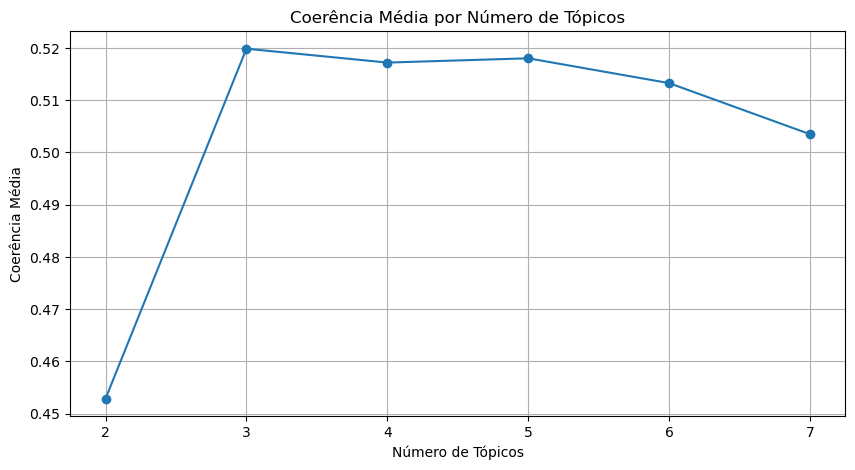

In [16]:
results, best_result = find_best_parameters(dct,
                                            corpus, 
                                            texts, 
                                            start=2, 
                                            end=10, 
                                            alphas=[0.01, 0.1, 'symmetric', 'asymmetric'], 
                                            etas=[0.01, 0.1, 'symmetric'])

plot_coherence_by_num_topics(results)

In [17]:
# Melhores parâmetros para o LDA
print(best_result)

{'num_topics': 4, 'alpha': 'asymmetric', 'eta': 0.1, 'coherence': 0.5483306523616582}


In [18]:
# Aplicando o LDA
num_topics = 5 
lda_model = train_lda(corpus, 
                      dct, 
                      num_topics=best_result['num_topics'],
                      alpha=best_result['alpha'],
                      eta=best_result['eta'])
vis = visualize_lda_model(lda_model, corpus, dct)

# Exibir a visualização do LDA
pyLDAvis.display(vis)


In [19]:
# Exibindo os tópicos e os principais termos associados a cada um
for i, topic in lda_model.show_topics(formatted=True, num_topics=5, num_words=10):
    print(f"Tópico {i+1}: {topic}\n")

Tópico 1: 0.014*"collapse" + 0.012*"provide" + 0.011*"company" + 0.011*"technology" + 0.010*"service" + 0.010*"business" + 0.009*"solution" + 0.008*"product" + 0.007*"management" + 0.006*"industry"

Tópico 2: 0.012*"user" + 0.010*"online" + 0.008*"people" + 0.008*"app" + 0.008*"platform" + 0.008*"allow" + 0.007*"time" + 0.007*"create" + 0.007*"social" + 0.006*"help"

Tópico 3: 0.022*"marketing" + 0.018*"design" + 0.017*"web" + 0.016*"service" + 0.015*"business" + 0.014*"mobile" + 0.012*"digital" + 0.012*"company" + 0.011*"medium" + 0.011*"content"

Tópico 4: 0.035*"company" + 0.022*"exploration" + 0.021*"property" + 0.019*"gold" + 0.018*"canada" + 0.017*"project" + 0.012*"development" + 0.012*"mining" + 0.011*"mineral" + 0.011*"locate"



##### Salvar o modelo LDA

In [20]:
with open(ROOT_DIR / SOURCE_SUBDIR / 'lda_model.pkl', 'wb') as hldafile:
    pickle.dump(lda_model, hldafile)

##### Os quatro tópicos identificados são relativos às seguintes áreas:

*Tópico 1*: Serviços Empresariais e Tecnologia
Este tópico parece ser relativo a empresas que oferecem serviços empresariais e soluções tecnológicas. Os termos que apóiam isso são "provide", "technology", "service", "solution" e "management";

*Tópico 2*: Plataformas Digitais e Engajamento do Usuário
Este tópico aponta a empresas envolvidas com plataformas digitais, aplicativos e redes sociais. Os termos que apóiam são "user", "online", "app", "platform" e "social";

*Tópico 3*: Marketing e Design Digital
Este tópico parece ser relativo a marketing e design, particularmente no espaço digital.
Os termos que apóiam isso são "marketing", "design", "web", "digital", "content" e "mobile";

*Tópico 4*: Mineração e Exploração
Este tópico é visivelmente focado em empresas do setor de mineração e exploração.
Os termos importantes são "exploration", "property", "gold", "mining" e "mineral".

Não se destacou nenhum tópico relativo a "tratamento de água", porém pode estar inserido nos 
tópicos 1 e 4, o primeiro devido ao uso de tecnologias mais genéricas, e o segundo pela necessidade e soluções necessárias relacionadas com água na mineração. Esta teoría vai ser validada ou não ao verificar se as empresas com os termos específicos caem apenas nos dois
grupos de tópicos.





In [21]:
# Salvar a visualização da distância entre tópicos em html
pyLDAvis.save_html(vis, str(ROOT_DIR / SOURCE_SUBDIR / 'lda_visualization.html'))

##### Adicionar o índice do tópico (LDA) a cada registro

In [22]:
def assign_topics_to_docs(lda_model, corpus):
    # Somando 1 para alinhar com os tópicos do LDAvis
    topics = [max(doc, key=lambda x: x[1])[0] + 1 for doc in lda_model[corpus]]
    return topics

# Associando tópicos aos registros e adicionando ao DataFrame
df['topic'] = assign_topics_to_docs(lda_model, corpus)


In [23]:
df.to_parquet(FULL_DATA_FILE_NAME)

##### Verificar em quais tópicos cairam os registros com os termos propostos no enunciado

In [24]:
# Lista dos índices dos registros especificados obtidos utilizando os termos originais
registros_indices = [3181, 11018, 4400, 4786, 368, 10311]

# Filtrando os registros especificados e seus tópicos dominantes
registros_selecionados = df.loc[registros_indices, ['description', 'topic']]

# Exibindo os resultados
print(registros_selecionados)

                                             description  topic
3181   "jet set is a line of hot tubs that boast stun...      1
11018  "4deep inwater imaging is a privately owned, h...      1
4400   "imagine housing solutions that offer: 90% red...      1
4786   "aquatic informatics provides leading software...      1
368    "we are using advanced stem cell and cell cult...      1
10311  "the product is a software that works on cell ...      1


Tópico 1 confirmado para os termos sugeridos pelo enunciado. Será verificado agora
o caso ao adicionar o termo "water".

##### Análise dos documentos com pelo menos um termo e seu tópico

In [25]:
# Lista dos índices dos registros especificados obtidos adicionando o termo "water"
registros_indices = [18229, 354, 10182, 16544, 5008, 5231, 10707, 1936, 13391,
                     16914, 10547, 10299, 11179, 16280, 5897, 89, 8677, 2154,
                     15972]

# Filtrando os registros especificados e seus tópicos dominantes
registros_selecionados = df.loc[registros_indices, ['description', 'topic']]

# Exibindo os resultados
print(registros_selecionados)

                                             description  topic
18229  "greenlife water is the leading provider of wa...      2
354    "o waste r/o out door water vending, electroni...      4
10182  "o waste r/o out door water vending, electroni...      4
16544  "our vision is to create a cost effective, tec...      2
5008   "sanzfield allows homeowners and small communi...      1
5231   "water is our future! without water we do not ...      1
10707  "demizine takes artifical intelligence (ai) an...      1
1936   "aquatech waterproofing has been keeping water...      4
13391  "tablâ€™eau filtered water provides exceptiona...      4
16914  "puritas energy is a green tech company which ...      1
10547  "fer-pal infrastructure is proud to offer a ce...      4
10299  "swirltex has developed a membrane filtration ...      1
11179  "edgewater exploration is a canadian based min...      4
16280  "homebeaver is an innovative new automation sy...      2
5897   "we are fredsense technologies, a

Nota-se os tópicos 1 e 4 são dominantes, algo já teorizado.

#### Análise de Distribuição dos Termos 

In [26]:
def get_indices_with_water_terms(df):
    # Filtrar registros com qualquer contagem de termos relacionados à água maior que 0
    filtered_df = df[(df['original_water_term_count'] > 0) | (df['altered_water_term_count'] > 0)]
    # Retornar os índices desses registros
    return filtered_df.index.tolist()


In [27]:
# Uso da função
indices_with_water_terms = get_indices_with_water_terms(df)
print(f"Índices com termos relacionados à água: {indices_with_water_terms}")

Índices com termos relacionados à água: [43, 89, 134, 354, 368, 381, 575, 590, 595, 781, 844, 964, 1061, 1137, 1143, 1365, 1417, 1509, 1532, 1538, 1539, 1604, 1606, 1726, 1739, 1854, 1936, 2040, 2063, 2096, 2179, 2258, 2452, 2705, 2917, 3072, 3102, 3126, 3181, 3258, 3411, 3502, 3610, 3623, 3671, 3688, 3729, 3844, 3864, 4090, 4118, 4123, 4148, 4400, 4447, 4628, 4730, 4753, 4786, 4843, 4847, 4850, 4925, 4930, 4937, 4969, 4989, 5008, 5034, 5163, 5231, 5299, 5472, 5532, 5799, 5842, 5897, 5905, 5953, 5968, 6177, 6191, 6225, 6317, 6347, 6432, 6448, 6469, 6604, 6767, 6850, 7087, 7097, 7143, 7148, 7167, 7592, 7707, 7784, 7822, 7832, 7901, 8083, 8261, 8351, 8357, 8473, 8481, 8677, 8746, 8999, 9799, 10124, 10170, 10182, 10216, 10279, 10295, 10298, 10299, 10311, 10316, 10413, 10414, 10484, 10489, 10547, 10575, 10605, 10663, 10707, 10760, 10896, 10898, 10997, 11018, 11178, 11440, 11532, 11546, 11549, 11944, 12049, 12084, 12085, 12097, 12193, 12216, 12238, 12403, 12481, 12538, 12564, 12635, 12766, 

In [28]:
def count_docs_by_topic_with_water_terms(df):
    # Filtrar registros com qualquer contagem de termos relacionados à água maior que 0
    filtered_df = df[(df['original_water_term_count'] > 0) | (df['altered_water_term_count'] > 0)]
    # Agrupar os registros filtrados por tópico e contar os registros em cada grupo
    topic_counts = filtered_df.groupby('topic').size()
    return topic_counts


In [29]:
docs_by_topic_with_water_terms = count_docs_by_topic_with_water_terms(df)
print("Quantidade de Documentos por Tópico (com termos relacionados à água):")
print(docs_by_topic_with_water_terms)


Quantidade de Documentos por Tópico (com termos relacionados à água):
topic
1    129
2     40
4     74
dtype: int64


In [30]:

def sample_indices_with_water_by_topic(df, sample_size=1):
    # Filtrar registros com a ocorrência do termo "water"
    df_with_water = df[df['altered_water_term_count'] > 0]
    # Verificar se há grupos com menos registros do que o sample_size desejado
    group_sizes = df_with_water.groupby('topic').size()
    min_size = group_sizes.min()
    if min_size < sample_size:
        print(f"Aviso: Um ou mais grupos têm menos registros do que o sample_size desejado ({sample_size}). Reduzindo sample_size para {min_size}.")
        sample_size = min_size
    # Agrupar por tópico e pegar uma amostra de cada
    sampled_indices = df_with_water.groupby('topic').apply(lambda x: x.sample(n=sample_size, random_state=1)).index.get_level_values(1)
    return sampled_indices

In [31]:
# Obtenção dos principais dados para análise qualitativa inicial. Tópico vs Análise da descrição
sampled_indices = sample_indices_with_water_by_topic(df, sample_size=2)
for index in sampled_indices:
    print(f"Índice: {index}, Tópico: {df.at[index, 'topic']}, Descrição: {df.at[index, 'clean_description'][:100]}...")

Índice: 18177, Tópico: 1, Descrição: earth smart offer eco friendly calgary agriculture solution gardening solution lawn care solution li...
Índice: 16186, Tópico: 1, Descrição: code4armourâ„¢ medical band speak emergency design autism parkinson epilepsy follow pre launch offer...
Índice: 590, Tópico: 2, Descrição: taphax real time water consumption tool save money promote sustainable lifestyle address intangibili...
Índice: 10997, Tópico: 2, Descrição: feel uneasy navigate new water want know friendâ€ ™ s location look good place launch boat anchor ni...
Índice: 8261, Tópico: 4, Descrição: water proofing foundation parkade concrete wood structure 25 year coating water proofing experience ...
Índice: 15115, Tópico: 4, Descrição: petrojet oilfield service company thirty year experience place ultra short radius lateral oil gas re...


In [32]:
def show_clean_description_by_index(df, index):
    # Verificar se o índice existe no DataFrame
    if index in df.index:
        # Retornar a descrição limpa para o índice fornecido
        return df.at[index, 'clean_description']
    else:
        # Mensagem de erro se o índice não for encontrado
        return "Índice não encontrado no DataFrame."


In [33]:
# Visualiza a descrção completa
index = 4367 
clean_description = show_clean_description_by_index(df, index)
print(f"Descrição Limpa para o Índice {index}:")
print(clean_description)

Descrição Limpa para o Índice 4367:
vayoola bear enable crowdfunder focus 100 cultivate awesome product idea fund reality happen weâ€ ™ develop self serve technology ease burden crowdfunding project promotion


##### Análise para Busca de Novos Termos

In [34]:
# Filtrar registros que pertencem ao Tópico 4 e têm termos relacionados à água
filtered_df = df[(df['topic'] == 2) & ((df['original_water_term_count'] > 0) | (df['altered_water_term_count'] > 0))]

# Exibir índice e descrição desses registros
for index, row in filtered_df.iterrows():
    print(f"Índice: {index}, Descrição: {row['description'][:100]}...")
    # Use 'row['clean_description']' se preferir usar a descrição limpa

Índice: 43, Descrição: "for people on the go who want to have easy access to small items like pens and earbuds, the kombine...
Índice: 381, Descrição: "our electronic road flare (eb 300 ) is powered by ultra-bright leds that are specialized for roadsi...
Índice: 590, Descrição: taphax is a real time water consumption tool to save money and promote a sustainable lifestyle to ad...
Índice: 1143, Descrição: "employ everyone is a platform for all self-employees in your community. this is the first place you...
Índice: 1365, Descrição: "ontarieau is currently the only local brand of sparkling water from ontario. our primary competitio...
Índice: 1604, Descrição: "nise building a smart-kitchen ecosystem by enabling parents, foodies, and busy professionals to aut...
Índice: 2179, Descrição: "splashcheck is a smart device you leave in your pool or hot tub that monitors the chemical balance ...
Índice: 2452, Descrição: goldoon the world's first learning and smart self-watering planter goldoon i

In [35]:
# Lista de termos relacionados ao tratamento de água conforme o exercício
original_water_terms = ["waste and water", "water quality", "water efficiency", 
                        "water contamination", "human consumption", "water resources"]

altered_water_terms = original_water_terms + ['water']

extended_water_terms = original_water_terms + ["water treatment", "clear water", "water consumption",
                                               "water purification", "filtered water", "drinking water",
                                               "water recycling", "treat wastewater", "treat the wastewater",
                                               "wastewater treatment" "water filtration", "water analysis"]
# Aplicar a função ao DataFrame
df['extended_water_term_count'] = df['clean_description'].apply(lambda x: count_water_terms(x, extended_water_terms))


##### Análises com os Termos Extendidos

In [36]:
# Visualizando as descrições com maior contagem de termos originais
top_water_descriptions = df.sort_values(by='extended_water_term_count', ascending=False).head(20)
#print(top_water_descriptions[['description', 'extended_water_term_count']])
top_water_descriptions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 14550 to 3688
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   name                       20 non-null     object
 1   description                20 non-null     object
 2   employees                  20 non-null     object
 3   total_funding              20 non-null     object
 4   city                       20 non-null     object
 5   subcountry                 20 non-null     object
 6   lat                        20 non-null     object
 7   lng                        20 non-null     object
 8   clean_description          20 non-null     object
 9   original_water_term_count  20 non-null     int64 
 10  altered_water_term_count   20 non-null     int64 
 11  topic                      20 non-null     int64 
 12  extended_water_term_count  20 non-null     int64 
dtypes: int64(4), object(9)
memory usage: 2.2+ KB


In [37]:
# Filtrar registros com termos estendidos relacionados à água
df_with_extended_terms = df[df['extended_water_term_count'] > 0]

# Agrupar esses registros por tópico e contar os registros em cada grupo
topic_distribution = df_with_extended_terms.groupby('topic').size()

print("Distribuição dos Registros com Termos Estendidos por Tópico:")
print(topic_distribution)

Distribuição dos Registros com Termos Estendidos por Tópico:
topic
1    33
2     6
4    10
dtype: int64


##### Análise Qualitativa dos Termos Associados aos Principais Tópicos

In [38]:
# Extraindo uma amostra das descrições dos registros no Tópico 1 com termos estendidos
topic_1_samples = df[(df['topic'] == 1) & (df['extended_water_term_count'] > 0)]['description'].sample(n=min(5, len(df[(df['topic'] == 1) & (df['extended_water_term_count'] > 0)])), random_state=1)

print("Amostra de Descrições no Tópico 1:")
for desc in topic_1_samples:
    print(f"- {desc}\n")

# Extraindo uma amostra das descrições dos registros no Tópico 4 com termos estendidos
topic_4_samples = df[(df['topic'] == 4) & (df['extended_water_term_count'] > 0)]['description'].sample(n=min(5, len(df[(df['topic'] == 4) & (df['extended_water_term_count'] > 0)])), random_state=1)

print("Amostra de Descrições no Tópico 4:")
for desc in topic_4_samples:
    print(f"- {desc}\n")


Amostra de Descrições no Tópico 1:
- "inspired by nature, our mission at loonskin labs is to provide the conditions for dynamic, inorganic structures to self assemble in useful ways. we have developed the world's first platform manufacturing technique that uses fluid dynamics to grow synthetic circulatory systems rapidly into silicone membranes. we can now create flexible, durable, flat delivery systems, to exchange heat or fluids, filter materials, or create fractal reinforced light weight structures. our first application is in wearable circulatory systems for personal climate control.our product will prevent heat stroke in athletes, treat burn wounds, and prevent bed sore development. we can also employ our technology in heat capture, water purification, and energy storage. we also plan on selling the equipment to manufacture to consumers under a creative commons license to enable people everywhere to use this groundbreaking, platform, patent-pending technology."

- "swirltex has de

Identificados os seguintes comportamentos:  
Tópico 1 (Tratamento de Água e Aplicações Relacionadas):  
**Tratamento de Água**: Existem descrições que mencionam explicitamente o tratamento de água ou purificação, como a "Swirltex" desenvolvendo sistemas de filtração de membrana para tratamento de águas residuais e a "Zenon Environmental" focada em sistemas de tratamento de água baseados em membranas.  
**Aplicações Inovadoras**: Algumas empresas estão aplicando tecnologias inovadoras ao tratamento de água, como a "Loonskin Labs" com sistemas circulatórios sintéticos para controle climático pessoal e aplicações em purificação de água.  
**Soluções Descentralizadas**: A "Newterra" oferece soluções descentralizadas para tratamento de água e águas residuais, indicando uma abordagem modular e escalável.  
  
Tópico 4 (Soluções de Infraestrutura e Eficiência Hídrica):  
**Melhoria da Qualidade da Água**: A "Fer-Pal Infrastructure" oferece soluções para melhorar a qualidade da água, indicando um foco em infraestrutura e manutenção de sistemas hídricos.  
**Sustentabilidade e Purificação**: A "Tabl'eau Filtered Water" promove a sustentabilidade através da purificação da água da torneira, reduzindo a necessidade de água engarrafada.  
**Diversidade de Aplicações**: Algumas descrições, como a do "FTI Foodtech International Inc.", mencionam aplicações diversificadas de purificação de água, desde consumo até uso industrial.  


### Salva Dataframe com Dados Inferidos

In [39]:
# Salvar os dados processados para intercâmbio com outros testes se for o caso
df.to_parquet(FULL_DATA_FILE_NAME)

### Criação do Modelo - Exercício 1

#### Seleção de Amostra para Rotulagem

Usar o código abaixo para gerar novas amostras, senão usar o arquivo já salvo (caso ja'tenha sido gerado)

In [40]:
# Seleção de amostra de registros relevantes
#relevant_samples = df[df['extended_water_term_count'] > 0].sample(n=20, random_state=1)
# Seleção de amostra de registros não relevantes
#non_relevant_samples = df[df['extended_water_term_count'] == 0].sample(n=20, random_state=1)
# Combine as amostras em um DataFrame para rotulagem
#samples_for_labeling = pd.concat([relevant_samples, non_relevant_samples])
# Exibir os índices das amostras selecionadas para revisão e rotulagem manual
#print(samples_for_labeling.index.tolist())

#### Análise das descrições para rotulação

In [41]:
# Exportação da amostra para visualização em editor

# Filtra registros pela lista de índices
#df_selected = df.loc[samples_for_labeling.index.tolist(), ['description']]
# Exportar para CSV
#df_selected.to_csv(ROOT_DIR / SOURCE_SUBDIR / 'descricoes_selecionadas.csv', index=True)

In [42]:
# Leitura das amostras previamente geradas
df_selected = pd.read_csv(ROOT_DIR / SOURCE_SUBDIR / 'descricoes_selecionadas.csv', index_col=0)

In [43]:
df_selected

,description
10547,"""fer-pal infrastructure is proud to offer a ce..."
13014,"""vista credit corp is a residential equipment ..."
15046,purlucid treatment solutions is a cutting-edge...
19306,"""h2o innovation is known for its state of the ..."
590,taphax is a real time water consumption tool t...
1417,"""the group currently operates mainly in the fi..."
16123,"""acuva technologies is developing ultraviolet ..."
10663,"""provider of water data analysis software inte..."
18177,"""earth smart offers eco friendly calgary agric..."
11018,"""4deep inwater imaging is a privately owned, h..."


In [44]:
suggested_labels = [
    (10547, "Relevante"),
    (13014, "Menos relevante"),
    (15046, "Relevante"),
    (19306, "Relevante"),
    (590, "Menos relevante"),
    (1417, "Menos relevante"),
    (16123, "Relevante"),
    (10663, "Relevante"),
    (18177, "Menos relevante"),
    (11018, "Relevante"),
    (11546, "Relevante"),
    (14641, "Relevante"),
    (13391, "Relevante"),
    (6177, "Não relevante"),
    (15972, "Relevante"),
    (13693, "Relevante"),
    (10311, "Relevante"),
    (7097, "Menos relevante"),
    (4786, "Relevante"),
    (16565, "Não relevante"),
    (5516, "Não relevante"),
    (10729, "Não relevante"),
    (9792, "Não relevante"),
    (8552, "Não relevante"),
    (5526, "Não relevante"),
    (13913, "Não relevante"),
    (17247, "Não relevante"),
    (4367, "Não relevante"),
    (11252, "Não relevante"),
    (8121, "Não relevante"),
    (8287, "Não relevante"),
    (15625, "Não relevante"),
    (8246, "Não relevante"),
    (8314, "Não relevante"),
    (12045, "Não relevante"),
    (8901, "Não relevante"),
    (1847, "Não relevante"),
    (8596, "Não relevante"),
    (10109, "Não relevante"),
    (6469, "Menos relevante")
]

In [45]:
# Salvar rótulos
labels_dict = dict(suggested_labels)
df_selected['label'] = df_selected.index.map(labels_dict)
df_selected.head()

,description,label
10547,"""fer-pal infrastructure is proud to offer a ce...",Relevante
13014,"""vista credit corp is a residential equipment ...",Menos relevante
15046,purlucid treatment solutions is a cutting-edge...,Relevante
19306,"""h2o innovation is known for its state of the ...",Relevante
590,taphax is a real time water consumption tool t...,Menos relevante


In [46]:
# Criando um dataframe com todos os dados
df_final = df.merge(df_selected[['label']], left_index=True, right_index=True, how='inner')

# Restringir tfidf_matrix aos registros rotulados
tfidf_matrix_restrita = tfidf_matrix[df_final.index]

In [47]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 590 to 19306
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   name                       40 non-null     object
 1   description                40 non-null     object
 2   employees                  40 non-null     object
 3   total_funding              40 non-null     object
 4   city                       40 non-null     object
 5   subcountry                 40 non-null     object
 6   lat                        40 non-null     object
 7   lng                        40 non-null     object
 8   clean_description          40 non-null     object
 9   original_water_term_count  40 non-null     int64 
 10  altered_water_term_count   40 non-null     int64 
 11  topic                      40 non-null     int64 
 12  extended_water_term_count  40 non-null     int64 
 13  label                      40 non-null     object
dtypes: int64(4),

In [50]:
# salvar os registros selecionados
df_selected.to_parquet(ROOT_DIR / SOURCE_SUBDIR /'Selected_Data.parquet')


# Salvar os registros rotulados, deve conter os indices originais
df_final.to_parquet(ROOT_DIR / SOURCE_SUBDIR /'Labeled_Data.parquet')

# Salvando o vetorizador alinhado com os dados selecionados
joblib.dump(tfidf_matrix_restrita, ROOT_DIR / SOURCE_SUBDIR / 'tfidf_matrix_restrita.pkl')

['/media/pabloernesto/Seagate Expansion Drive/Work/Projects/Desafios/FirstDecision/Prospect-Canadian-Water-Companies/Data/tfidf_matrix_restrita.pkl']